### **Part 1**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * evoked state
* Communication subspaces across different areas
  * correlation
  * dimensionality
* Information flow across subspaces
  * direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* (to do) Hierarchy of information flow  across these subspaces
* (to do) Relation between different information flow channels
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN networks

**Problems**
* Correlation_delay data is spiky
  * If 1ms slide, data can not changed a lot
  * Try window step smaller
* Correlation_delay data is too large
* No obvious pattern in Correlation_delay data
  * Delay period longer
  * Shuffle data as refer
  * revert roles of area1 and area2 in Correlation_delay data, delta MI
  * MI_delay, delta_MI_delay, across areas
* Develop intuition for data visualization
  * small try, such PSTH, receptive-field of single unit or across units
  * See more raw data and neuro paper
* Across time & across conditions considering differently

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [6]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_id = 799864342
session = cache.get_session_data(session_id)

### Task1 explore proper visual stimuli

In [7]:
print(session.stimulus_names)

['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


In [8]:
spon_stim_table = session.get_stimulus_table('spontaneous')
print(spon_stim_table['stimulus_condition_id'].value_counts())
spon_stim_table.head()

0    16
Name: stimulus_condition_id, dtype: int64


,start_time,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,
0,29.005689,spontaneous,89.072529,60.066840,0
3646,1001.068151,spontaneous,1290.059739,288.991588,0
3797,1588.559270,spontaneous,1590.310709,1.751439,0
3998,2189.811871,spontaneous,2220.837819,31.025948,0
21999,2821.339779,spontaneous,2851.381559,30.041780,0


In [9]:
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1590.310709,2,drifting_gratings,1592.312419,4,2.00171,246
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3801,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1599.318261,2,drifting_gratings,1601.319921,1,2.00166,249
3802,null,null,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",null,1602.320789,2,drifting_gratings,1604.322439,null,2.00165,250


In [10]:
print(drift_stim_table['temporal_frequency'].value_counts())
print(drift_stim_table['orientation'].value_counts())
print(drift_stim_table['stimulus_condition_id'].value_counts())

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
315.0    75
180.0    75
45.0     75
225.0    75
90.0     75
270.0    75
135.0    75
0.0      75
null     30
Name: orientation, dtype: int64
250    30
286    15
256    15
263    15
262    15
261    15
260    15
259    15
258    15
257    15
255    15
265    15
254    15
253    15
252    15
251    15
249    15
248    15
247    15
264    15
266    15
285    15
267    15
284    15
283    15
282    15
281    15
280    15
279    15
278    15
277    15
276    15
275    15
274    15
273    15
272    15
271    15
270    15
269    15
268    15
246    15
Name: stimulus_condition_id, dtype: int64


In [11]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        stim_table -- _description_

    Keyword Arguments:
        bin -- _description_ (default: {0.1})
        period -- _description_ (default: {2})

    Returns:
        _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

In [12]:
def drift_tuning_curve(area, unit_id, drift_stim_table, bin=0.1):

    temp_freq_list = [1.0, 2.0, 4.0, 8.0, 15.0]
    ori_list = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

    tunning_curve_matrix = np.empty([len(temp_freq_list), len(ori_list)])

    for i in range(len(temp_freq_list)):
        for j in range(len(ori_list)):
            stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq_list[i]) 
                                & (drift_stim_table['orientation'] == ori_list[j])]
            response_matrix = spike_matrix(area, stim_table)

            # spikes/s, average spikes across trails and time bins
            response_units = response_matrix.mean(0).mean(0) / bin

            if unit_id < len(response_units):
                tunning_curve_matrix[i, j] = response_units[unit_id]
            else:
                print(f'There is no neuron {unit_id} in {area}')
                return

    print(response_matrix.shape)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(tunning_curve_matrix)

    ax.set_xticks(range(len(ori_list))+np.array([0.5]))
    ax.set_xticklabels(ori_list)
    ax.set_xlabel('orientation')
    ax.set_yticks(range(len(temp_freq_list))+np.array([0.5]))
    ax.set_yticklabels(temp_freq_list)
    ax.set_ylabel('temporal_freqency')
    ax.set_title(f'grating_tuning_curve of neuron {unit_id} in {area}, spikes/s')

    f.colorbar(im)
    plt.show()

    return tunning_curve_matrix

**tunning curve of neurons in VISam**

(15, 20, 29)


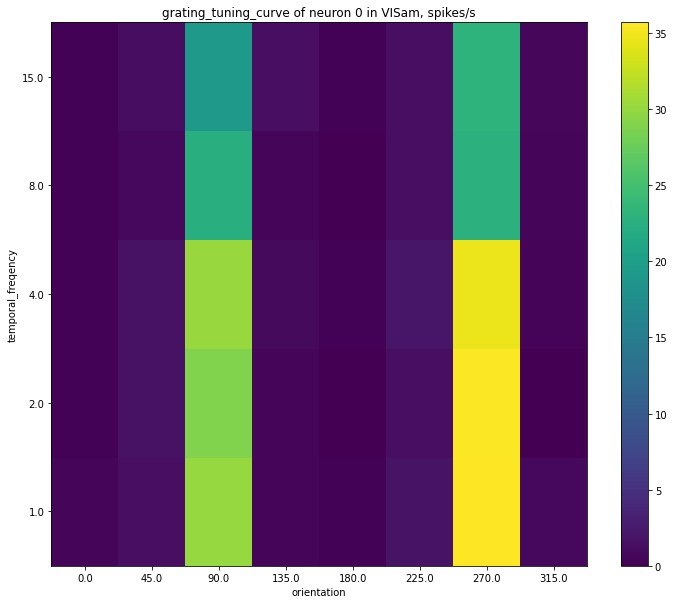

(15, 20, 29)


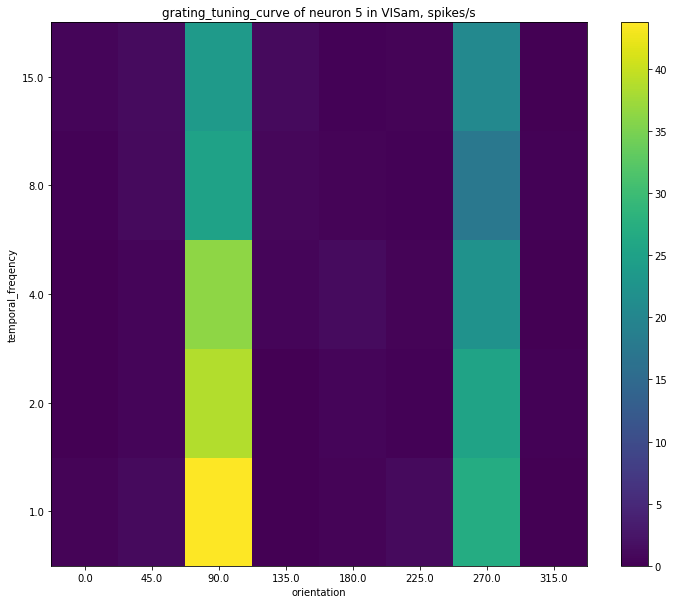

(15, 20, 29)


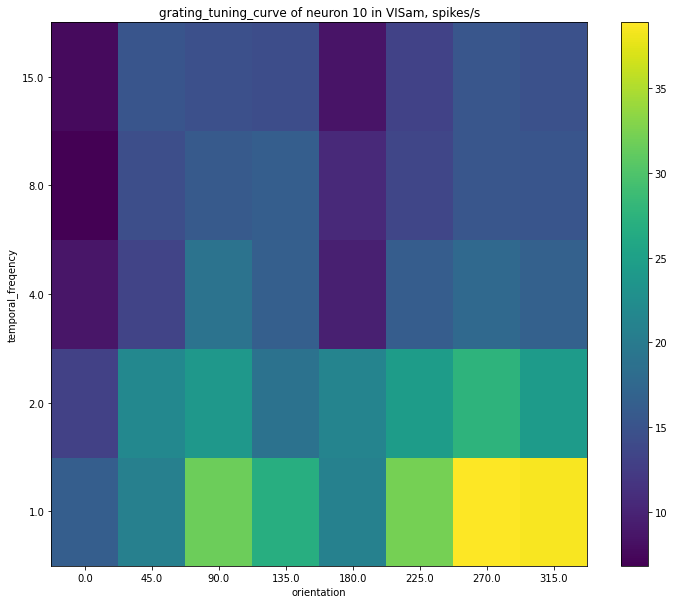

(15, 20, 29)


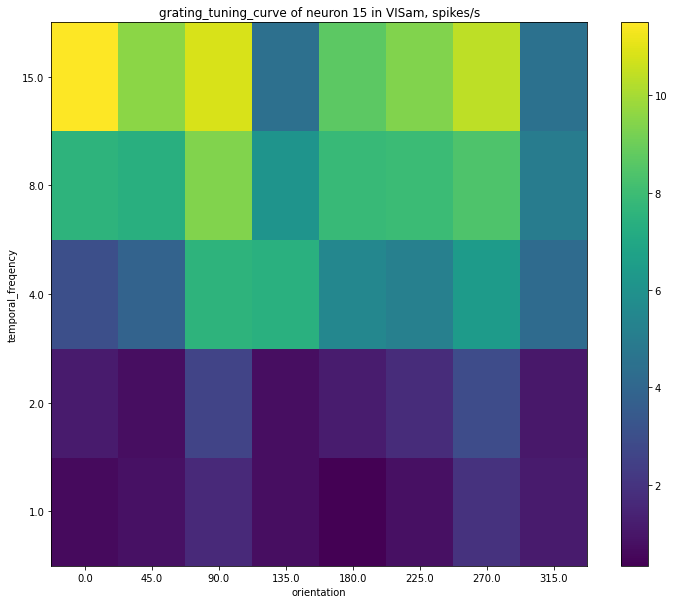

(15, 20, 29)


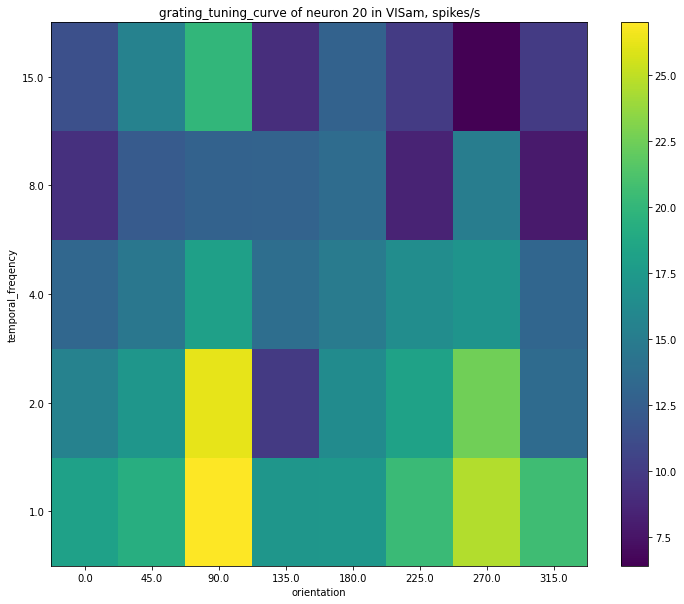

In [13]:
unit_list = [0, 5, 10, 15, 20]

for i in range(len(unit_list)):
    drift_tuning_curve(area='VISam', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

**tunning curve of neurons in CA1**

(15, 20, 109)


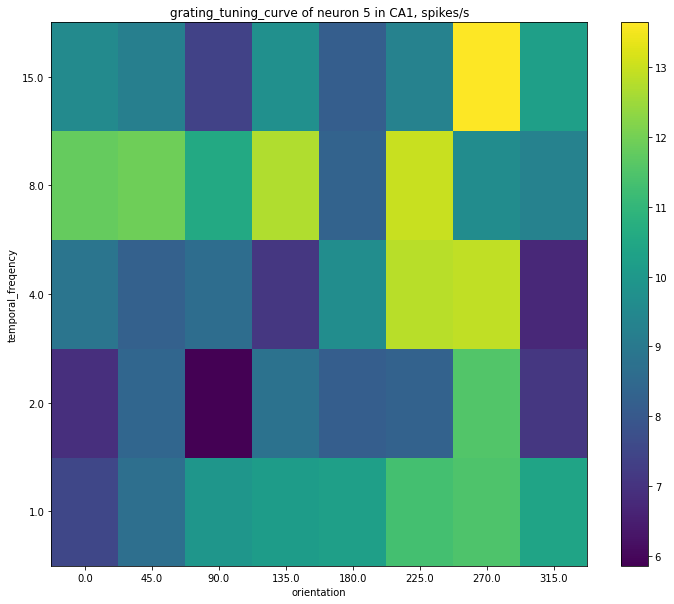

(15, 20, 109)


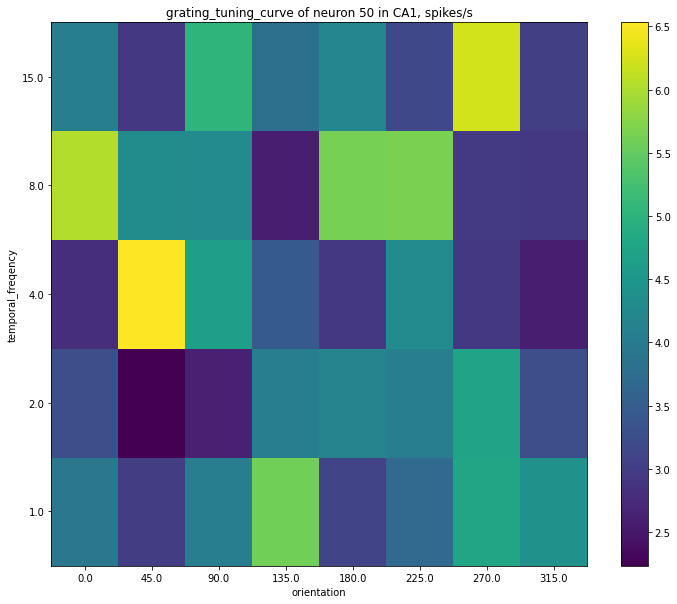

(15, 20, 109)


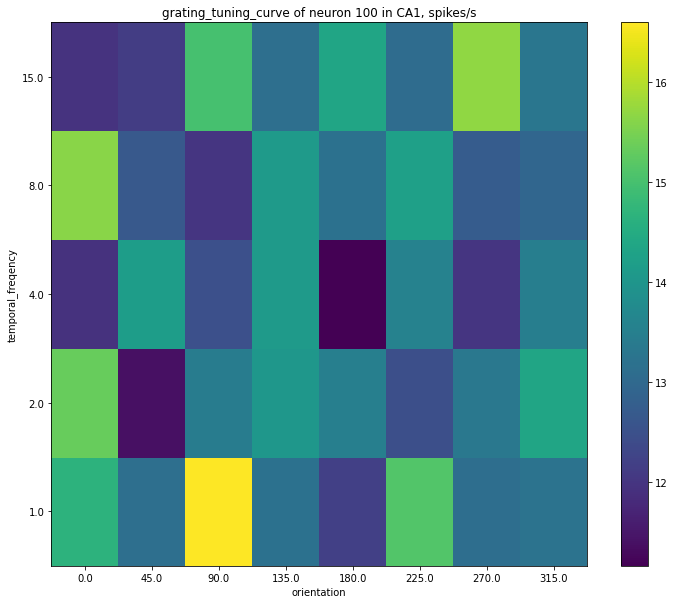

In [14]:
unit_list = [5, 50, 100]

for i in range(len(unit_list)):
    drift_tuning_curve(area='CA1', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

In [15]:
def drift_PSTH(area, unit_id, drift_stim_table, temp_freq=1.0, ori=90.0, bin=0.1, period=2):

    stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq) 
                        & (drift_stim_table['orientation'] == ori)]
    response_matrix = spike_matrix(area, stim_table, bin=bin)

    # spikes/s, average spikes across trails and time bins, shape=bins*neurons
    response_matrix = response_matrix.mean(0) / bin

    if unit_id < response_matrix.shape[1]:
        unit_psth = response_matrix[:, unit_id]
    else:
        print(f'There is no neuron {unit_id} in {area}')
        return

    print(response_matrix.shape)

    time_bins = np.linspace(0, period, 9)
    tick_bins = time_bins/bin
    label_bins = time_bins

    plt.figure()
    plt.plot(unit_psth)
    plt.title(f'PSTH of neuron {unit_id} in {area}')
    plt.xlabel('time, s')
    plt.xticks(ticks=tick_bins, labels=label_bins)
    plt.ylabel('firing rates, spikes/s')
    plt.show()

    return unit_psth

**PSTH of neurons in VISam**

(20, 29)


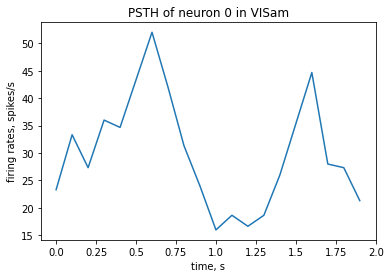

(20, 29)


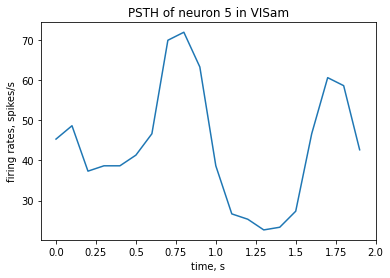

(20, 29)


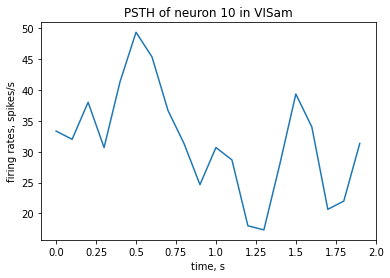

(20, 29)


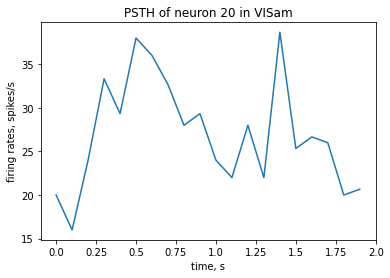

In [16]:
unit_list = [0, 5, 10, 20]

for i in range(len(unit_list)):
    drift_PSTH(area='VISam', unit_id=unit_list[i], drift_stim_table=drift_stim_table)

**PSTH of different bins in VISam neuron0**

In [17]:
def drift_PSTH_bins(area, unit_id, drift_stim_table, temp_freq=1.0, ori=90.0, bin=0.1, period=2):

    stim_table = drift_stim_table[(drift_stim_table['temporal_frequency'] == temp_freq) 
                        & (drift_stim_table['orientation'] == ori)]
    response_matrix = spike_matrix(area, stim_table, bin=bin)

    # spikes/time_bin, average spikes across trails and time bins, shape=bins*neurons
    response_matrix = response_matrix.mean(0)

    if unit_id < response_matrix.shape[1]:
        unit_psth = response_matrix[:, unit_id]
    else:
        print(f'There is no neuron {unit_id} in {area}')
        return

    print(response_matrix.shape)

    time_bins = np.linspace(0, period, 9)
    tick_bins = time_bins/bin
    label_bins = time_bins

    plt.figure()
    plt.plot(unit_psth)
    plt.title(f'PSTH of neuron {unit_id} in {area}, bin={bin}')
    plt.xlabel('time, s')
    plt.xticks(ticks=tick_bins, labels=label_bins)
    plt.ylabel('firing rates, spikes/time_bin')
    plt.show()

    return unit_psth

(20, 29)


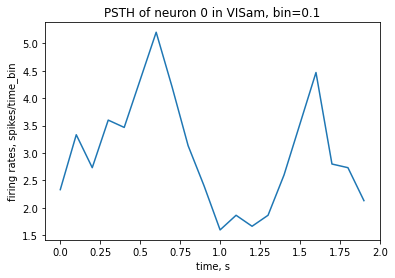

(40, 29)


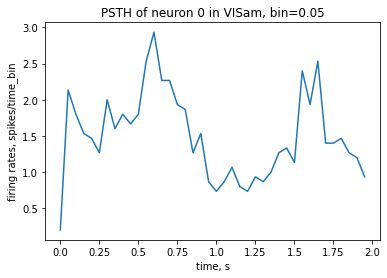

(200, 29)


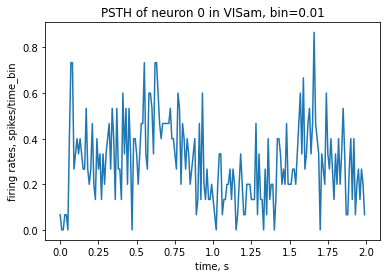

(400, 29)


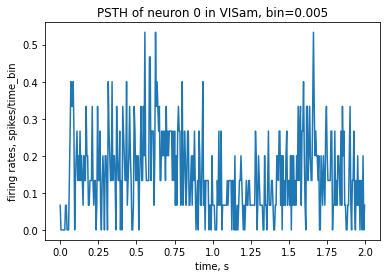

(2000, 29)


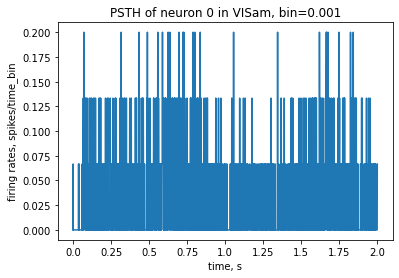

In [18]:
bin_list = [0.1, 0.05, 0.01, 0.005, 0.001]

for i in range(len(bin_list)):
    drift_PSTH_bins(area='VISam', unit_id=0, drift_stim_table=drift_stim_table, bin=bin_list[i])

### Task2 CCA correlation across areas

In [19]:
def corr_area_pairs(X_a, X_b, n_components = 3):
    """corr_area_pairs _summary_

    _extended_summary_

    Arguments:
        X_a -- _description_
        X_b -- _description_
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) 

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

In [20]:
areas = session.structure_acronyms
print(len(areas))
print(areas)

# delete nan in areas
while np.nan in areas:
    areas.remove(np.nan)

# delete area with no units
for area in areas:
    units = session.units[session.units["ecephys_structure_acronym"] == area]
    if units.shape[0] == 0:
        areas.remove(area)
print(len(areas))
print(areas)

18
['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
16
['VISam', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


In [31]:
def CCA_across_areas(stim_table, areas, component=0):
    
    areas_corr_matrix = np.empty([len(areas), len(areas)])

    for i in range(len(areas)):
        for j in range(len(areas)):
            response_matrix = spike_matrix(area = areas[i], stim_table=stim_table)
            res_mat_i = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                                response_matrix.shape[2])
            response_matrix = spike_matrix(area = areas[j], stim_table=stim_table)
            res_mat_j = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                                response_matrix.shape[2])

            corr_ij, w, z = corr_area_pairs(res_mat_i, res_mat_j)
            areas_corr_matrix[i, j] = corr_ij[component]

    return areas_corr_matrix

16
['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']


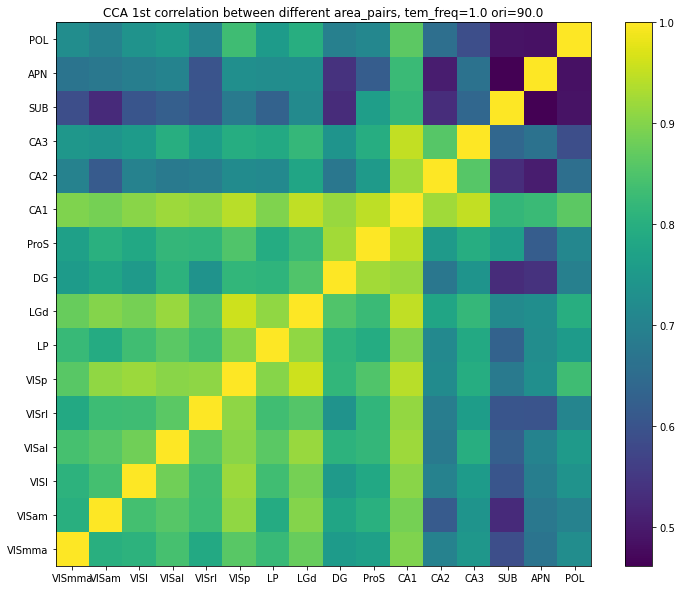

In [28]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
print(len(areas))
print(areas)

stim_table_trial = drift_stim_table[(drift_stim_table['temporal_frequency'] == 1.0) 
                    & (drift_stim_table['orientation'] == 90.0)]

areas_corr_matrix = CCA_across_areas(stim_table=stim_table_trial, areas=areas_sorted)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas))+np.array([0.5]))
ax.set_xticklabels(areas)
ax.set_yticks(range(len(areas))+np.array([0.5]))
ax.set_yticklabels(areas)
ax.set_title('CCA 1st correlation between different area_pairs, tem_freq=1.0 ori=90.0')

f.colorbar(im)

16
['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']


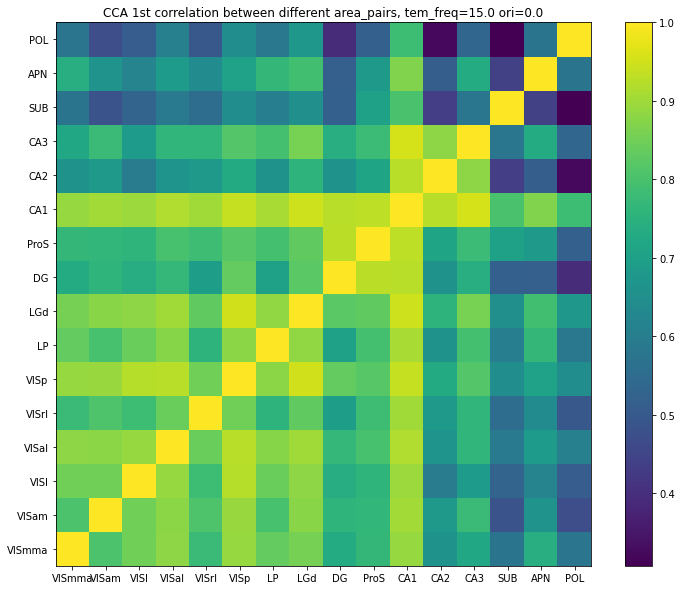

In [29]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
print(len(areas))
print(areas)

stim_table_trial = drift_stim_table[(drift_stim_table['temporal_frequency'] == 15.0) 
                    & (drift_stim_table['orientation'] == 0.0)]

areas_corr_matrix = CCA_across_areas(stim_table=stim_table_trial, areas=areas_sorted)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas))+np.array([0.5]))
ax.set_xticklabels(areas)
ax.set_yticks(range(len(areas))+np.array([0.5]))
ax.set_yticklabels(areas)
ax.set_title('CCA 1st correlation between different area_pairs, tem_freq=15.0 ori=0.0')

f.colorbar(im)

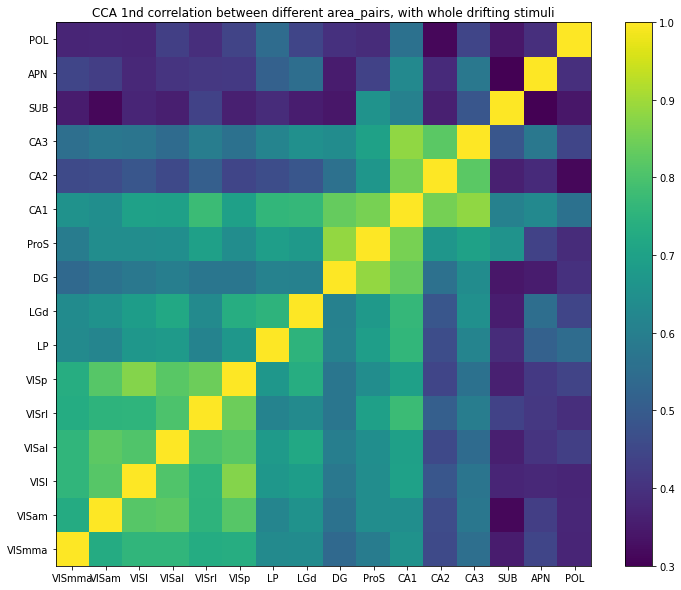

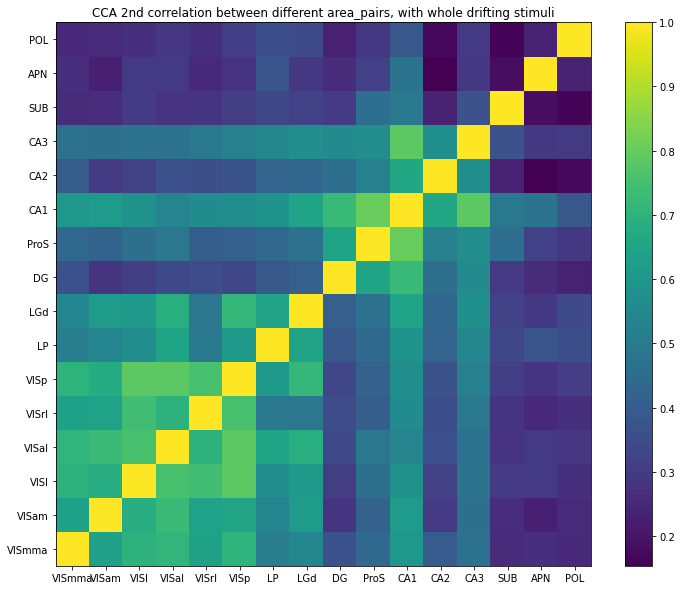

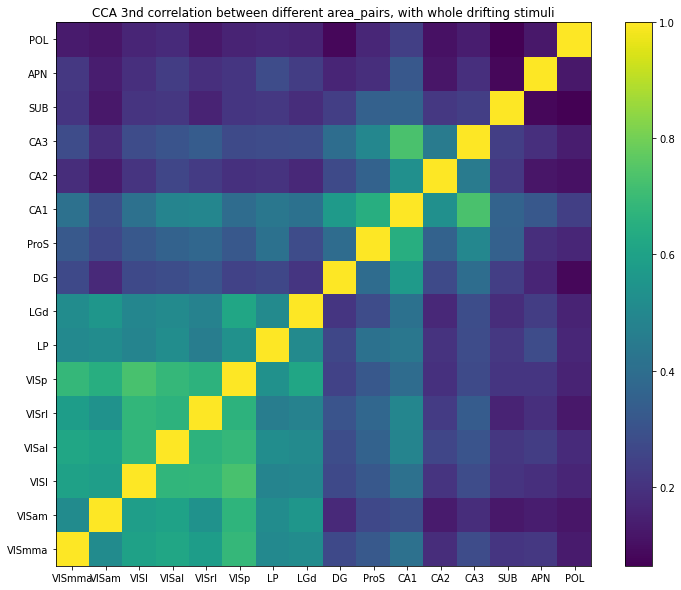

In [32]:
# sorted after CCA for blocking
areas_sorted = ['VISmma', 'VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']

for i in range(3):
    areas_corr_matrix = CCA_across_areas(stim_table=drift_stim_table, areas=areas_sorted, component=i)

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(areas_corr_matrix)

    ax.set_xticks(range(len(areas))+np.array([0.5]))
    ax.set_xticklabels(areas)
    ax.set_yticks(range(len(areas))+np.array([0.5]))
    ax.set_yticklabels(areas)
    ax.set_title(f'CCA {i+1}nd correlation between different area_pairs, with whole drifting stimuli')

    f.colorbar(im)

### Task3 CCA correlation across areas with time_delay

### Task4 Dimensionity of subspaces intra-areas and inter-areas